<a href="https://colab.research.google.com/github/MohsenHmy/NN_masters/blob/main/hw2_%3CHomayouni_Mohammadmohsen%3E_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN HW 2 - Simple RNN training
### Adapted from the EEML2019 Tutorial on RNNs

The objective is to analyze the training of various RNNs on simple datasets and doing some analysis.  

## Imports

In [ ]:
# @title Imports

from __future__ import absolute_import, division, print_function

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import random
from matplotlib import pyplot as plt

sns.set_style("ticks")

# Vanilla RNN

Implement basic Vanilla RNN.

   $$ h_t = f( W_{ih} \times x_t + W_{hh} \times h_{t-1}  + b) $$

   $$ y_t = W_{ho} \times h_t $$
   
   Where
   
   * $x_t$ input at time $t$
   * $h_t$ hidden state at time $t$
   * $W_{ih}$ input-to-hidden mapping (trainable)
   * $w_{hh}$ hidden-to-hidden mapping (trainable)
   * $b$ bias (trainable)
   * $f$ non-linearity chosen (usually tanh)
   * $W_{ho}$ hidden-to-output mapping (trainable)
   * $y_t$ is the output of the RNN at time $t$

### Implement Vanilla RNN recurrence model

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=20, bias=False, activation=nn.Tanh):
        super().__init__()
        self._hidden_size = hidden_size
        self._activation = activation()

        # Input to Hidden
        self.in_to_hidden = nn.Linear(input_size, hidden_size, bias=bias)
        # Hidden to Hidden
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size, bias=bias)
        # Hidden to Output
        self.hidden_to_out = nn.Linear(hidden_size, output_size, bias=bias)

    def step(self, input_step, hidden=None):
        if hidden is None:
            hidden = torch.zeros(1, self._hidden_size).to(input_step.device)

        # RNN Math: h_t = tanh(W_ih * x_t + W_hh * h_{t-1})
        h_t = self._activation(self.in_to_hidden(input_step) + self.hidden_to_hidden(hidden))
        # y_t = W_ho * h_t
        output = self.hidden_to_out(h_t)
        return output, h_t

    def forward(self, x, teacher_forcing_prob=0.0, warm_start=0):
        outputs = []
        hidden = None
        out = None

        # x shape expected: (seq_len, 1)
        for t in range(x.size(0)):
            # 1. Decide the input for this specific time step
            if t == 0 or t < warm_start:
                # Always use Ground Truth during Warm Start phase
                curr_input = x[t].unsqueeze(0)
            elif random.random() < teacher_forcing_prob:
                # Teacher Forcing: Use Ground Truth from the previous step's target
                curr_input = x[t].unsqueeze(0)
            else:
                # Self-Generation: Use the model's own previous output
                curr_input = out

            out, hidden = self.step(curr_input, hidden)
            outputs.append(out)

        return torch.stack(outputs).squeeze(1), hidden


## Train RNN on sine wave

Train the RNN on sine data - predict the next sine value from *predicted* sine values.

Predict   $$ sin (x +t \epsilon) $$ from $$ sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) $$

In particular, we want the network to predict the next value in a loop, conditioning the prediction on some initial values (provided) and all subsequent predictions.

To learn the prediction model, we will use *teacher forcing*. This means that when training the model, the input at time $t$ is the real sequence at time $t$, rather than the output produced by the model at $t-1$.

When we want to generate data from the model, we do not have access to the true sequence, so we do not use teacher forcing. However, in the case of our problem, we will also use *warm starting*, because we require multiple time steps to predict the next sine wave value (at least 2, for the initial value and for the step).

The code below unrolls the RNN core you have defined above, does the training using backprop though time and plots the real data ("ground truth"), the data generated during training ("train predictions") and the model samples "generated".


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

Running code @ cuda


In [ ]:
# Data setup: Sine wave
x_axis = np.arange(0, 20 * np.pi, 0.1)
y_train = np.sin(x_axis).reshape(-1, 1)

criterion = nn.MSELoss()

# The 8 Experiment Configurations from your assignment
experiments = [
    (0.0, 30, 0, "p=0.0 (Learning on own)"),
    (0.5, 30, 0, "p=0.5 (Default)"),
    (0.75, 30, 0, "p=0.75"),
    (1.0, 30, 0, "p=1.0 (Teacher Forcing)"),
    (0.5, 3, 0, "Small Unroll (3)"),
    (0.5, 62, 0, "Large Unroll (62)"),
    (0.0, 62, 2, "Warm Start 2, Unroll 62, p=0"),
    (1.0, 3, 2, "Warm Start 2, Unroll 3, p=1")
]

all_results = {}

for p, unroll, warm, label in experiments:
    print(f"Training Experiment: {label}...")
    net = VanillaRNN(hidden_size=20).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.002)

    losses = []
    for iteration in range(1500): # Iterations to see convergence
        # Select random slice of the sine wave
        start = np.random.choice(range(len(y_train) - unroll))
        train_seq = torch.from_numpy(y_train[start:start+unroll]).float().to(device)

        # Targets are shifted by 1
        inputs = train_seq[:-1]
        targets = train_seq[1:]

        optimizer.zero_grad()
        preds, _ = net(inputs, teacher_forcing_prob=p, warm_start=warm)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    all_results[label] = {"losses": losses, "model": net}

print("All experiments completed.")

Training Experiment: p=0.0 (Learning on own)...
Training Experiment: p=0.5 (Default)...
Training Experiment: p=0.75...
Training Experiment: p=1.0 (Teacher Forcing)...
Training Experiment: Small Unroll (3)...
Training Experiment: Large Unroll (62)...
Training Experiment: Warm Start 2, Unroll 62, p=0...
Training Experiment: Warm Start 2, Unroll 3, p=1...
All experiments completed.


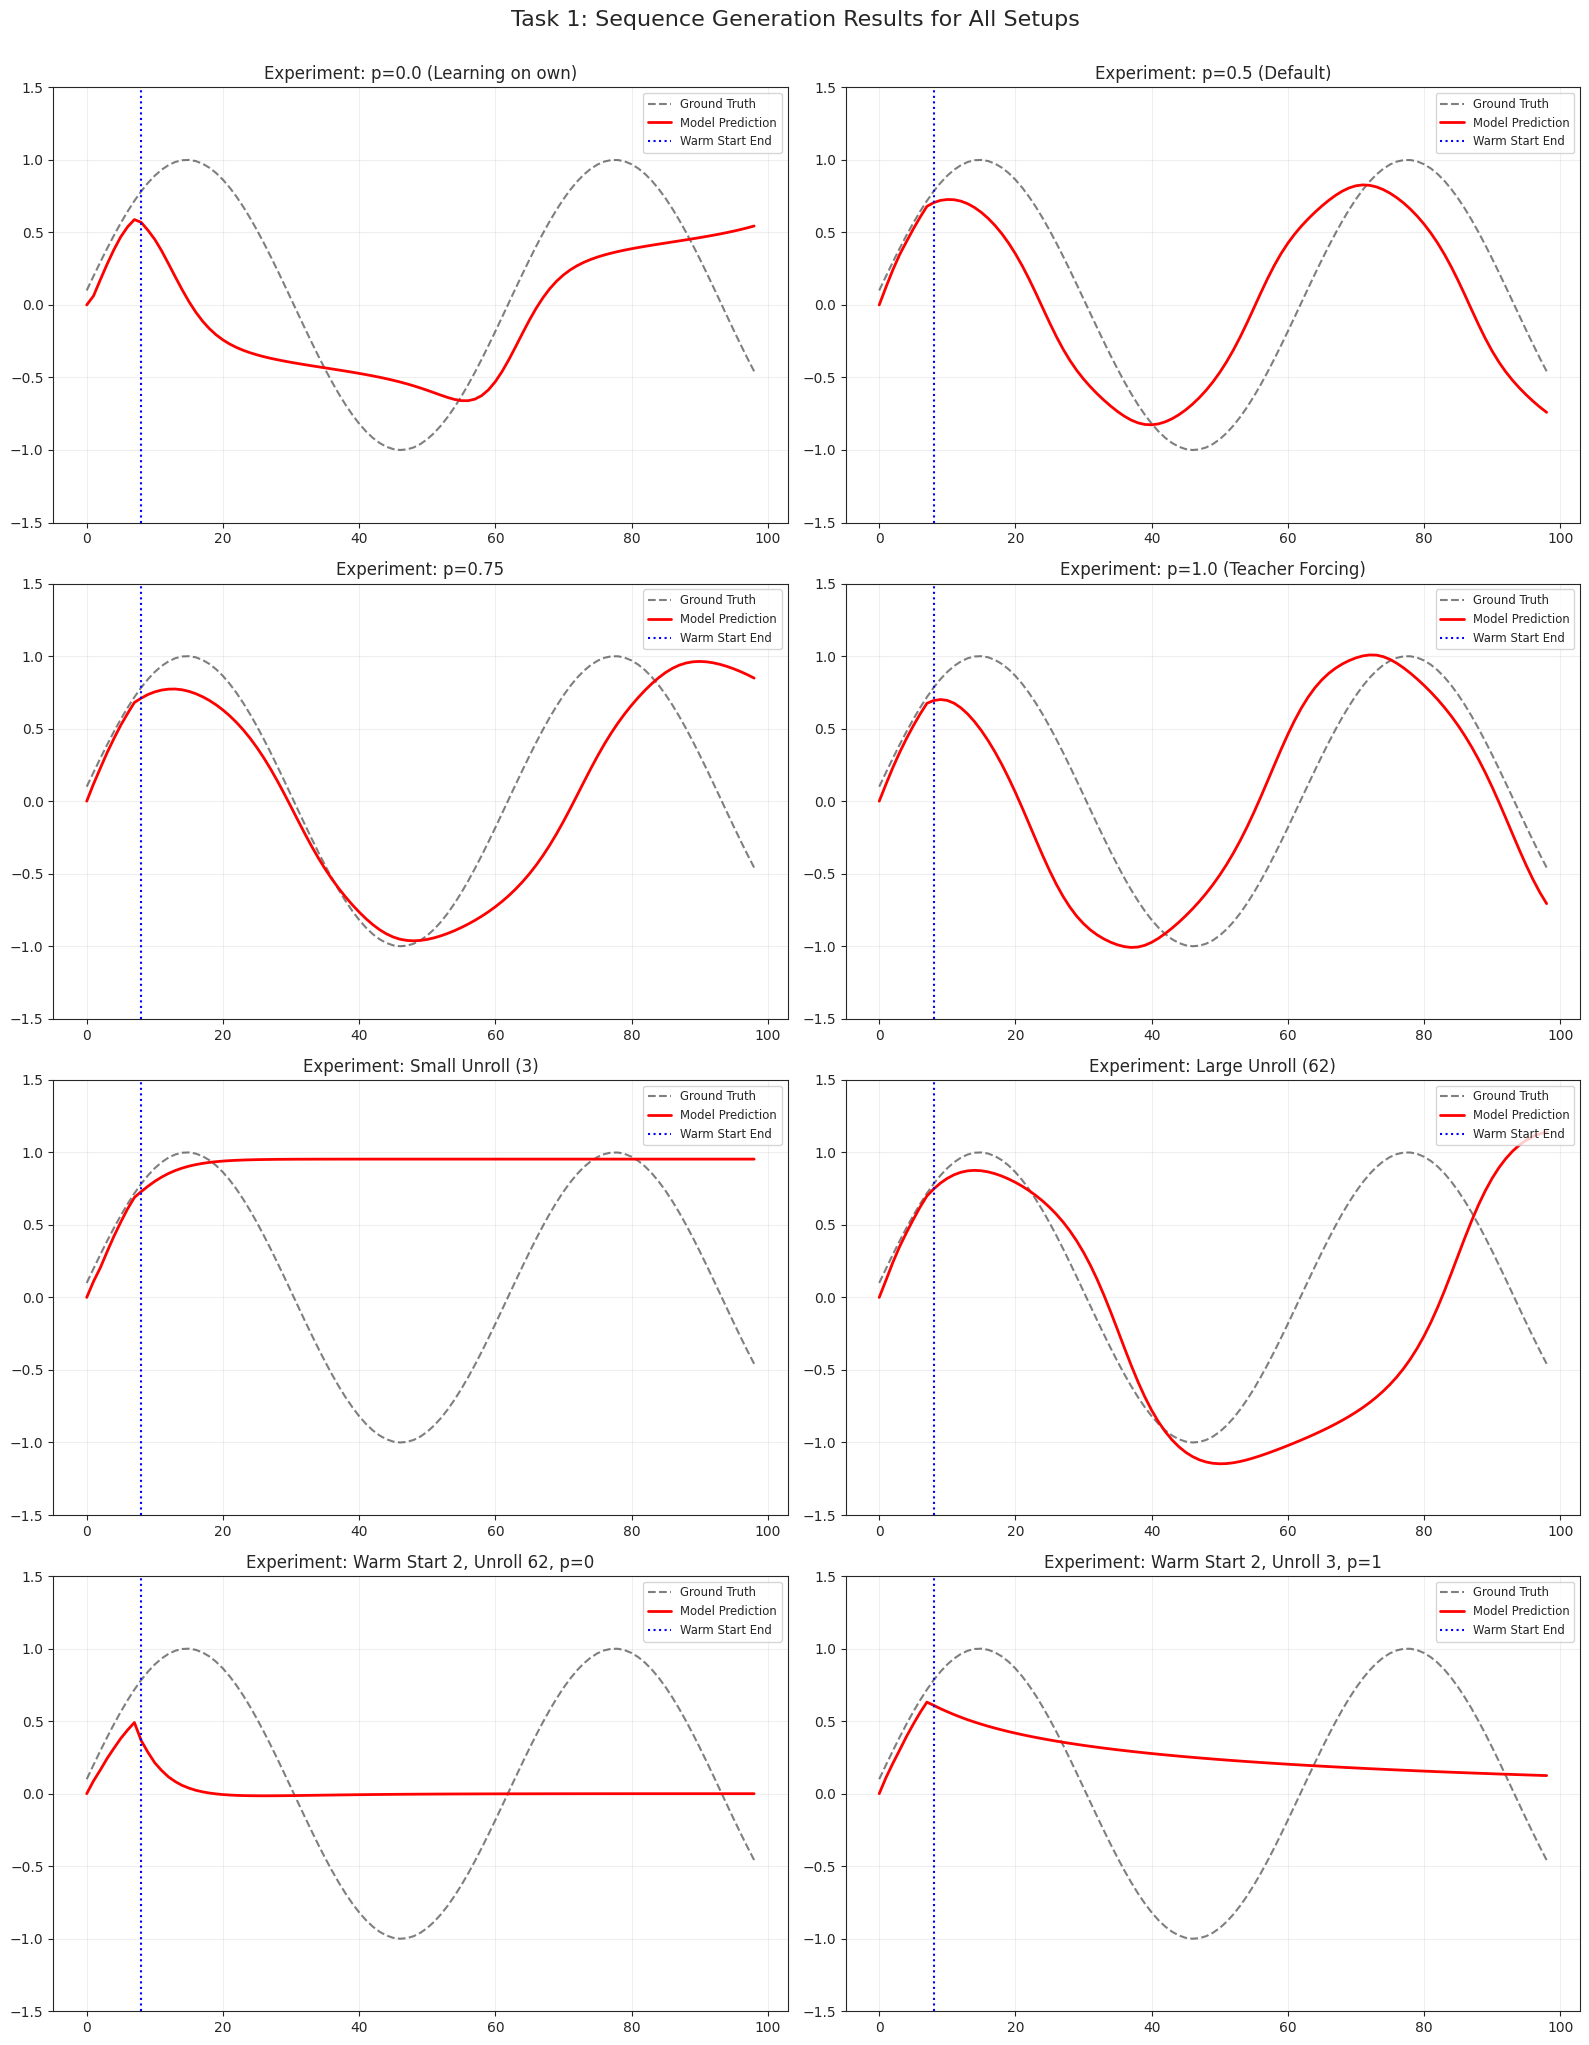

Experiment Setup               | Final Loss  
---------------------------------------------
p=0.0 (Learning on own)        | 0.302174
p=0.5 (Default)                | 0.008567
p=0.75                         | 0.003914
p=1.0 (Teacher Forcing)        | 0.001209
Small Unroll (3)               | 0.010024
Large Unroll (62)              | 0.010179
Warm Start 2, Unroll 62, p=0   | 0.466610
Warm Start 2, Unroll 3, p=1    | 0.004530


In [ ]:
def plot_all_experiments(all_results, y_train, device):
    # Set up a grid of plots (4 rows, 2 columns)
    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    axes = axes.flatten()

    # We will test on a sequence of 100 points
    test_points = 100
    test_data = torch.from_numpy(y_train[:test_points]).float().to(device)

    # Each experiment had a specific warm start we should respect or test against
    # but for the report, testing with a standard WARM_START=8 shows the model's potential
    test_warm_start = 8

    for i, (label, data) in enumerate(all_results.items()):
        model = data["model"]
        model.eval()

        with torch.no_grad():
            # In test mode, we ALWAYS use p=0 (no teacher forcing)
            # We use the warm start to "prime" the hidden state
            preds, _ = model(test_data[:-1], teacher_forcing_prob=0.0, warm_start=test_warm_start)

        ax = axes[i]
        # Plot Ground Truth
        ax.plot(y_train[1:test_points], label="Ground Truth", color="black", linestyle="--", alpha=0.5)
        # Plot Model Generation
        ax.plot(preds.cpu().numpy(), label="Model Prediction", color="red", lw=2)

        # Draw a vertical line where the Warm Start ends
        ax.axvline(x=test_warm_start, color='blue', linestyle=':', label='Warm Start End')

        ax.set_title(f"Experiment: {label}")
        ax.set_ylim(-1.5, 1.5)
        ax.legend(loc='upper right', fontsize='small')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("Task 1: Sequence Generation Results for All Setups", fontsize=16, y=1.02)
    plt.show()

# Execute the plotting
plot_all_experiments(all_results, y_train, device)
print(f"{'Experiment Setup':<30} | {'Final Loss':<12}")
print("-" * 45)

for label, data in all_results.items():
    # We take the average of the last 50 iterations to get a stable "Final Loss"
    final_avg_loss = np.mean(data["losses"][-50:])
    print(f"{label:<30} | {final_avg_loss:.6f}")

**Note:** initialization is not fixed (we do not fix a random seed), so each time the cell is executed, the parameters take new initial values and hence training can lead to different results. What happens if you run it multiple times?

### What is worth trying/understanding here?

* Difference between teacher forcing and learning on own samples:
 * What are the pros and cons of teacher forcing?
* In which setup (combination of unroll_length and teacher forcing probability) is the model struggling to learn?
* How does warm starting affect test time prediction? Why?
* What happens if the structure of interest is much longer than the unroll length?

#Task 2

In [ ]:
!pip install torchmetrics[text] sacrebleu datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 82.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.4/591.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 46.8 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=d66e2ae4320c1c483f6b5c6d6cb26281127027afbccc4a6d6a972c92bdef90cb
  Stored in directory: /root/.cache/pip/wheels/93/8b/55/dd5978a069678c372520847cf84ba2ec539cb41917c00a2206
Successfully built ipadic


Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random, math, time
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from collections import Counter
from torchmetrics.text import BLEUScore
from torchmetrics.text import Perplexity

Data processing

In [ ]:
dataset = load_dataset("bentrevett/multi30k")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def build_vocab(data, lang):
    tokens = [word for item in data for word in item[lang].lower().split()]
    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    for word, _ in Counter(tokens).most_common(10000):
        if word not in vocab: vocab[word] = len(vocab)
    return vocab

de_vocab = build_vocab(dataset['train'], 'de')
en_vocab = build_vocab(dataset['train'], 'en')
rev_en_vocab = {v: k for k, v in en_vocab.items()}

def process_batch(batch):
    src_list, trg_list = [], []
    for item in batch:
        src_tokens = [1] + [de_vocab.get(w.lower(), 3) for w in item['de'].split()] + [2]
        trg_tokens = [1] + [en_vocab.get(w.lower(), 3) for w in item['en'].split()] + [2]
        src_list.append(torch.tensor(src_tokens))
        trg_list.append(torch.tensor(trg_tokens))
    return torch.nn.utils.rnn.pad_sequence(src_list), torch.nn.utils.rnn.pad_sequence(trg_list)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout, bidirectional):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        if bidirectional:
            self.fc_hid = nn.Linear(hid_dim * 2, hid_dim)
            self.fc_cell = nn.Linear(hid_dim * 2, hid_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        if self.bidirectional:
            hid_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
            cell_cat = torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)
            hidden = torch.tanh(self.fc_hid(hid_cat)).unsqueeze(0)
            cell = torch.tanh(self.fc_cell(cell_cat)).unsqueeze(0)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        return self.fc_out(output.squeeze(0)), hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder, self.decoder, self.device = encoder, decoder, device

    def forward(self, src, trg, tf_ratio=0.5):
        trg_len, batch_size = trg.shape[0], trg.shape[1]
        outputs = torch.zeros(trg_len, batch_size, self.decoder.output_dim).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            input = trg[t] if random.random() < tf_ratio else output.argmax(1)
        return outputs

Training

In [ ]:
def run_experiment(name, bidirectional=False, hid_dim=256, emb_dim=256, dropout=0.5, tf=0.5, batch_size=128, epochs=5):
    print(f"\n--- RUNNING: {name} ---")
    train_loader = DataLoader(dataset['train'], batch_size=batch_size, collate_fn=process_batch, shuffle=True)
    test_loader = DataLoader(dataset['test'], batch_size=batch_size, collate_fn=process_batch)

    model = Seq2Seq(Encoder(len(de_vocab), emb_dim, hid_dim, dropout, bidirectional),
                    Decoder(len(en_vocab), emb_dim, hid_dim, dropout), device).to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    history = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            output = model(src, trg, tf)
            loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        history.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1} Loss: {history[-1]:.4f}")

    # Evaluation
    model.eval()
    bleu_metric = BLEUScore()
    ppl_metric = Perplexity(ignore_index=0).to(device)
    all_preds, all_targets = [], []

    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0)
            ppl_metric.update(output[1:], trg[1:])

            preds = output[1:].argmax(2).T
            actuals = trg[1:].T
            for p, a in zip(preds, actuals):
                p_tokens = [rev_en_vocab[i.item()] for i in p if i.item() not in [0, 1, 2]]
                a_tokens = [rev_en_vocab[i.item()] for i in a if i.item() not in [0, 1, 2]]
                all_preds.append(" ".join(p_tokens))
                all_targets.append([" ".join(a_tokens)])

    final_bleu = bleu_metric(all_preds, all_targets).item()
    final_ppl = ppl_metric.compute().item()
    return {"loss": history, "bleu": final_bleu, "ppl": final_ppl}


Exeriments


--- RUNNING: Obj 1: Baseline (Hid 128, Drop 0.5) ---
Epoch 1 Loss: 5.7586
Epoch 2 Loss: 5.0631
Epoch 3 Loss: 4.8220
Epoch 4 Loss: 4.6676
Epoch 5 Loss: 4.5467

--- RUNNING: Obj 1: Baseline (Hid 256, Drop 0.5) ---
Epoch 1 Loss: 5.4916
Epoch 2 Loss: 4.8779
Epoch 3 Loss: 4.6321
Epoch 4 Loss: 4.4175
Epoch 5 Loss: 4.2516

--- RUNNING: Obj 1: Baseline (Hid 256, Drop 0.5, tf=0) ---
Epoch 1 Loss: 5.5697
Epoch 2 Loss: 5.1097
Epoch 3 Loss: 4.8783
Epoch 4 Loss: 4.6647
Epoch 5 Loss: 4.4935

--- RUNNING: Obj 1: High Capacity (Hid 512) ---
Epoch 1 Loss: 5.3188
Epoch 2 Loss: 4.7047
Epoch 3 Loss: 4.4192
Epoch 4 Loss: 4.2016
Epoch 5 Loss: 4.0035

--- RUNNING: Obj 2: Bidirectional ---
Epoch 1 Loss: 5.3251
Epoch 2 Loss: 4.7716
Epoch 3 Loss: 4.5873
Epoch 4 Loss: 4.4314
Epoch 5 Loss: 4.2727


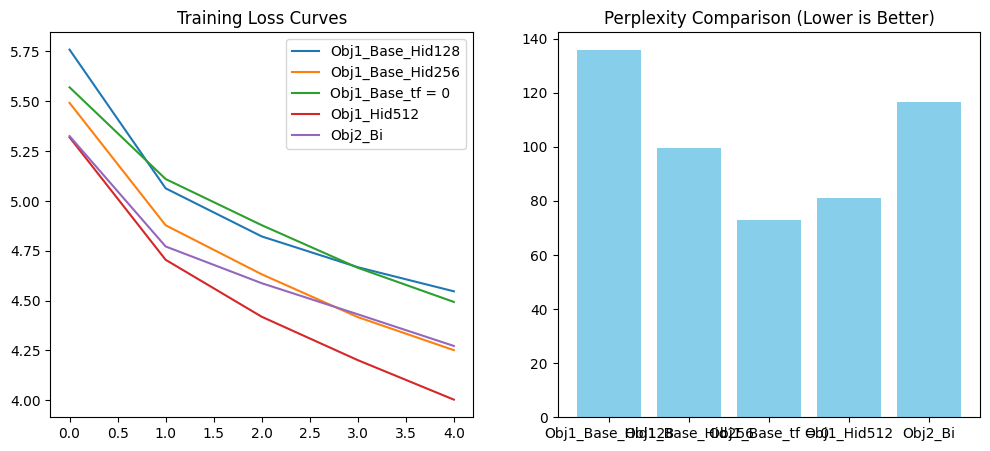

Obj1_Base_Hid128 -> BLEU: 0.0407 | PPL: 135.58
Obj1_Base_Hid256 -> BLEU: 0.0749 | PPL: 99.41
Obj1_Base_tf = 0 -> BLEU: 0.0798 | PPL: 73.08
Obj1_Hid512 -> BLEU: 0.0917 | PPL: 80.92
Obj2_Bi -> BLEU: 0.0613 | PPL: 116.41


In [ ]:

results = {}

# Selection of key experiments for the report
results['Obj1_Base_Hid128'] = run_experiment("Obj 1: Baseline (Hid 128, Drop 0.5)", bidirectional=False, hid_dim=128)
results['Obj1_Base_Hid256'] = run_experiment("Obj 1: Baseline (Hid 256, Drop 0.5)", bidirectional=False, hid_dim=256)
results['Obj1_Base_tf = 0'] = run_experiment("Obj 1: Baseline (Hid 256, Drop 0.5, tf=0)", bidirectional=False, hid_dim=256, tf=0)
results['Obj1_Hid512'] = run_experiment("Obj 1: High Capacity (Hid 512)", bidirectional=False, hid_dim=512)
results['Obj2_Bi'] = run_experiment("Obj 2: Bidirectional", bidirectional=True, hid_dim=512)

# --- GENERATE PLOTS ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for k, v in results.items(): plt.plot(v['loss'], label=k)
plt.title("Training Loss Curves"); plt.legend()

plt.subplot(1, 2, 2)
names = list(results.keys())
ppls = [v['ppl'] for v in results.values()]
plt.bar(names, ppls, color='skyblue')
plt.title("Perplexity Comparison (Lower is Better)")
plt.show()

for k, v in results.items():
    print(f"{k} -> BLEU: {v['bleu']:.4f} | PPL: {v['ppl']:.2f}")